# 네이버 영화 리뷰

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
# 데이터를 읽어봅시다. 

train_data = pd.read_table('./data/ratings_train.txt')

test_data = pd.read_table('data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    train_x = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        train_x.append(temp_X)

    test_x = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        test_x.append(temp_X)
    
    words = np.concatenate(train_x).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)

    vocab = ['<PAD>', '<BOS>', '<UNK>', '']+[key for key, _ in counter]

    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    train_x = list(map(wordlist_to_indexlist, train_x))
    test_x = list(map(wordlist_to_indexlist, test_x))
        
    return train_x, np.array(list(train_data['label'])), test_x, np.array(list(test_data['label'])), word_to_index
    
train_x, train_y, test_x, test_y, word_to_index = load_data(train_data, test_data) 

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


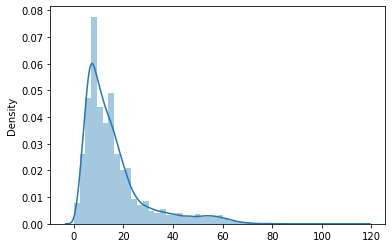

In [5]:
data = train_x + test_x
data_len = [len(d) for d in data]
data_len = np.array(data_len)

print('문장길이 평균 : ', np.mean(data_len))
print('문장길이 최대 : ', np.max(data_len))
print('문장길이 표준편차 : ', np.std(data_len))

sns.distplot(data_len)
plt.show()

In [6]:
max_tokens = np.mean(data_len) + 2 * np.std(data_len)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. \n\n\n'.format(np.sum(data_len < max_tokens) / len(data_len)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 





**Maxlen을 적용했을 때의 문장 길이 히스토그램**

문장길이 평균 :  13.342785129174542
문장길이 최대 :  41
문장길이 표준편차 :  8.215636904539625


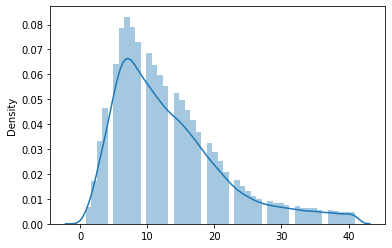

In [7]:
data = train_x + test_x
data_len = [len(d) for d in data if len(d) <= 41]
data_len = np.array(data_len)

print('문장길이 평균 : ', np.mean(data_len))
print('문장길이 최대 : ', np.max(data_len))
print('문장길이 표준편차 : ', np.std(data_len))

sns.distplot(data_len)
plt.show()

In [8]:
train_x = keras.preprocessing.sequence.pad_sequences(train_x,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

test_x = keras.preprocessing.sequence.pad_sequences(test_x,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)


"train shape: {} test shape:  {}".format(train_x.shape, test_x.shape)

'train shape: (146182, 41) test shape:  (49157, 41)'

## 3가지 모델로 훈련

1. LSTM
2. GRU
3. CNN


3가지 모델을 담는 Dictionary

In [9]:
models = {
    "lstm": [],
    "gru": [],
    "cnn": []
}

### 1. LSTM 모델

In [10]:
from itertools import product

vocab_size = len(index_to_word)

word_vector_dims = [16, 64]
hidden_layer_dims = [8, 16]

search_list = product(word_vector_dims, hidden_layer_dims)

for i, (word_vector_dim, hidden_layer_dim) in enumerate(search_list):

    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, word_vector_dim))
    model.add(keras.layers.LSTM(hidden_layer_dim))
    model.add(keras.layers.Dense(hidden_layer_dim, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    info = {
        "word_vector_dim": word_vector_dim,
        "hidden_layer_dim": hidden_layer_dim,
        "model": model,
        "history": None
    }
    models['lstm'].append(info)

### 2. GRU 모델

In [11]:
word_vector_dims = [16, 64]
hidden_layer_dims = [8, 16]

search_list = product(word_vector_dims, hidden_layer_dims)

for i, (word_vector_dim, hidden_layer_dim) in enumerate(search_list):

    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, word_vector_dim))
    model.add(keras.layers.GRU(hidden_layer_dim))
    model.add(keras.layers.Dense(hidden_layer_dim, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    info = {
        "word_vector_dim": word_vector_dim,
        "hidden_layer_dim": hidden_layer_dim,
        "model": model,
        "history": None
    }
    models['gru'].append(info)

### 3. CNN 모델

In [12]:
word_vector_dims = [16, 64]
hidden_layer_dims = [8, 16]

search_list = product(word_vector_dims, hidden_layer_dims)

for i, (word_vector_dim, hidden_layer_dim) in enumerate(search_list):

    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, word_vector_dim))
    model.add(keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(keras.layers.MaxPooling1D(5))
    model.add(keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(hidden_layer_dim, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    info = {
        "word_vector_dim": word_vector_dim,
        "hidden_layer_dim": hidden_layer_dim,
        "model": model,
        "history": None
    }
    models['cnn'].append(info)

In [13]:
EPOCHS = 20
for i, info in enumerate(models['lstm']):
    total_cnt = len(models['lstm'])
    model = info['model']
    history = model.fit(train_x, train_y, epochs=EPOCHS, validation_split=0.2, verbose=0)
    info['history'] = history
    print("({}/{}) word_vector_dim:{}  hidden_layer_dim:{}  acc:{:.4f}".format(i+1, total_cnt, info['word_vector_dim'], info['hidden_layer_dim'], history.history['val_accuracy'][-1]))

(1/4) word_vector_dim:16  hidden_layer_dim:8  acc:0.8435
(2/4) word_vector_dim:16  hidden_layer_dim:16  acc:0.8448
(3/4) word_vector_dim:64  hidden_layer_dim:8  acc:0.8417
(4/4) word_vector_dim:64  hidden_layer_dim:16  acc:0.8399


In [14]:
EPOCHS = 20
for i, info in enumerate(models['gru']):
    total_cnt = len(models['gru'])
    model = info['model']
    history = model.fit(train_x, train_y, epochs=EPOCHS, validation_split=0.2, verbose=0)
    info['history'] = history
    print("({}/{}) word_vector_dim:{}  hidden_layer_dim:{}  acc:{:.4f}".format(i+1, total_cnt, info['word_vector_dim'], info['hidden_layer_dim'], history.history['val_accuracy'][-1]))

(1/4) word_vector_dim:16  hidden_layer_dim:8  acc:0.8349
(2/4) word_vector_dim:16  hidden_layer_dim:16  acc:0.8337
(3/4) word_vector_dim:64  hidden_layer_dim:8  acc:0.8348
(4/4) word_vector_dim:64  hidden_layer_dim:16  acc:0.8330


In [15]:
EPOCHS = 20
for i, info in enumerate(models['cnn']):
    total_cnt = len(models['cnn'])
    model = info['model']
    history = model.fit(train_x, train_y, epochs=EPOCHS, validation_split=0.2, verbose=0)
    info['history'] = history
    print("({}/{}) word_vector_dim:{}  hidden_layer_dim:{}  acc:{:.4f}".format(i+1, total_cnt, info['word_vector_dim'], info['hidden_layer_dim'], history.history['val_accuracy'][-1]))

(1/4) word_vector_dim:16  hidden_layer_dim:8  acc:0.8197
(2/4) word_vector_dim:16  hidden_layer_dim:16  acc:0.8196
(3/4) word_vector_dim:64  hidden_layer_dim:8  acc:0.8338
(4/4) word_vector_dim:64  hidden_layer_dim:16  acc:0.8294


**각각의 모델(lstm, gru, cnn)들의 하이퍼파라미터를 변경해가며 학습을 했다. 그 중 각 모델의 최고 val_acc를 달성한 모델을 시각화하려 한다.**

In [16]:
lstm_acc = [info['history'].history['val_accuracy'][0] for info in models['lstm']]
gru_acc = [info['history'].history['val_accuracy'][0] for info in models['gru']]
cnn_acc = [info['history'].history['val_accuracy'][0] for info in models['cnn']]

best_lstm_index = lstm_acc.index(max(lstm_acc))
best_gru_index = gru_acc.index(max(gru_acc))
best_cnn_index = cnn_acc.index(max(cnn_acc))

best_lstm_model_history = models['lstm'][best_lstm_index]['history']
best_gru_model_history = models['gru'][best_gru_index]['history']
best_cnn_model_history = models['cnn'][best_cnn_index]['history']

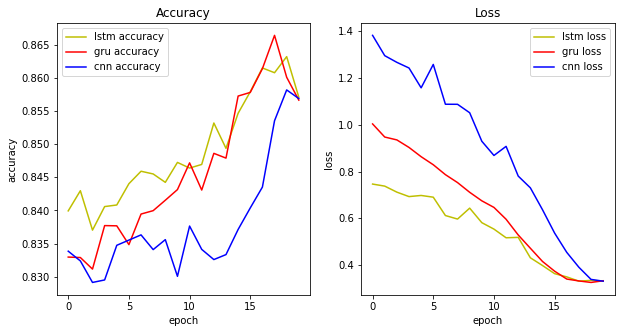

In [17]:
fig, (acc_ax, loss_ax) = plt.subplots(1,2, figsize=(10, 5))

acc_ax.plot(best_lstm_model_history.history['val_accuracy'][::-1], 'y', label='lstm accuracy')
acc_ax.plot(best_gru_model_history.history['val_accuracy'][::-1], 'r', label='gru accuracy')
acc_ax.plot(best_cnn_model_history.history['val_accuracy'][::-1], 'b', label='cnn accuracy')

acc_ax.set_xlabel('epoch')
acc_ax.set_ylabel('accuracy')
acc_ax.legend()
acc_ax.set_title("Accuracy")

loss_ax.plot(best_lstm_model_history.history['val_loss'][::-1], 'y', label='lstm loss')
loss_ax.plot(best_gru_model_history.history['val_loss'][::-1], 'r', label='gru loss')
loss_ax.plot(best_cnn_model_history.history['val_loss'][::-1], 'b', label='cnn loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend()
loss_ax.set_title("Loss")

plt.show()

위의 결과를 통해 모델을 선택해야 하는데, GRU의 Best Model이 안정적이라고 생각한다.

In [18]:
model = models['gru'][best_gru_index]['model']

## 자체학습 Word2Vec과 사전학습 Word2Vec 비교

**자체학습 Word2Vec**

In [19]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = 'data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [20]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("밥")

[('놔', 0.7119723558425903),
 ('1', 0.6914435029029846),
 ('잘못', 0.634893536567688),
 ('싫', 0.6231899857521057),
 ('공개', 0.6194628477096558),
 ('오버', 0.6143509745597839),
 ('후회', 0.6141495704650879),
 ('는구나', 0.61201012134552),
 ('녀석', 0.6068153977394104),
 ('코', 0.6049805879592896)]

**사전학습 Word2Vec**

In [21]:
from gensim.models import Word2Vec
import gensim
path = 'data/ko.bin'
word_vectors = Word2Vec.load(path)
word_vectors.wv.similar_by_word("밥")

[('스폰지', 0.6359171867370605),
 ('반찬', 0.6288836002349854),
 ('떡', 0.6208181381225586),
 ('계란', 0.6053064465522766),
 ('시럽', 0.6036492586135864),
 ('초콜릿', 0.6027452349662781),
 ('푸딩', 0.5942443609237671),
 ('국물', 0.5894560813903809),
 ('치킨', 0.589329719543457),
 ('비스킷', 0.5666051506996155)]

## Pretrained Word2Vec으로 학습하기

In [22]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [23]:
from tensorflow.keras.initializers import Constant

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, 
                                      embeddings_initializer=Constant(embedding_matrix), 
                                      input_shape=(None,),
                                      trainable=False))
model.add(keras.layers.GRU(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_x, train_y, epochs=20, validation_split=0.2)

Epoch 1/20
3655/3655 [==============================] - 34s 9ms/step - loss: 0.5956 - accuracy: 0.6581 - val_loss: 0.4672 - val_accuracy: 0.7793
Epoch 2/20
3655/3655 [==============================] - 32s 9ms/step - loss: 0.4561 - accuracy: 0.7872 - val_loss: 0.4423 - val_accuracy: 0.7957
Epoch 3/20
3655/3655 [==============================] - 32s 9ms/step - loss: 0.4293 - accuracy: 0.8022 - val_loss: 0.4291 - val_accuracy: 0.8010
Epoch 4/20
3655/3655 [==============================] - 32s 9ms/step - loss: 0.4134 - accuracy: 0.8102 - val_loss: 0.4197 - val_accuracy: 0.8061
Epoch 5/20
3655/3655 [==============================] - 32s 9ms/step - loss: 0.4051 - accuracy: 0.8139 - val_loss: 0.4122 - val_accuracy: 0.8118
Epoch 6/20
3655/3655 [==============================] - 32s 9ms/step - loss: 0.3928 - accuracy: 0.8203 - val_loss: 0.4100 - val_accuracy: 0.8139
Epoch 7/20
3655/3655 [==============================] - 32s 9ms/step - loss: 0.3864 - accuracy: 0.8239 - val_loss: 0.4184 - val_ac

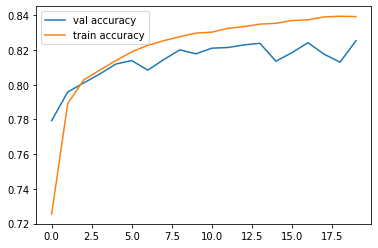

In [24]:
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(history.history['accuracy'], label='train accuracy')

_ = plt.legend()

### 고찰

영화리뷰 데이터를 통해 긍정 혹은 부정을 판단하는 모델을 만들었다. 모델학습에 있어서 가장 중요한것은 데이터이다. 데이터 중 앞의 5개만 확인을 해봐도 문제가 있었다. 하지만 이를 어떻게 수정할 것이냐는 질문에 답이 떠오르지 않았다. 당연히 총 20만개의 데이터를 전부 볼 수 없다. 적용하지 못했지만 생각했던 내용들을 기록하려 한다.

- 영어로 된 문장제거(사전학습된 한국어 임베딩을 사용하는 이유뿐만 아니라 영어로 쓰인 리뷰는 대게 이상했다)
- 확실히 부정적인 단어가 포함된 단어는 부정으로 처리(짜증, 욕)
- 확실히 긍정적인 단어가 포함된 단어는 긍정으로 처리(행복, 감사)